In [3]:
# import the kitti dataset from torch
import os

import torch
import torch.utils.data as data
import torchvision

In [8]:
dataset = torchvision.datasets.Kitti(download=True, root='data')
sample = dataset[0]

100%|██████████| 12569945557/12569945557 [10:10<00:00, 20590325.31it/s]


Extracting data/Kitti/raw/data_object_image_2.zip to data/Kitti/raw


100%|██████████| 5601213/5601213 [00:07<00:00, 772156.06it/s] 


Extracting data/Kitti/raw/data_object_label_2.zip to data/Kitti/raw


In [24]:
print(sample)

print(type(sample))
print(type(sample[1]))
import json

formatted_sample = json.dumps(sample[1], indent=4)
# print(formatted_sample)

sample_image, sample_target = dataset[0]
print(sample_target)


(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1242x375 at 0x166E9C550>, [{'type': 'Car', 'truncated': 0.0, 'occluded': 0, 'alpha': -1.55, 'bbox': [572.44, 181.56, 611.95, 219.71], 'dimensions': [1.66, 1.73, 3.05], 'location': [-0.82, 2.08, 33.4], 'rotation_y': -1.57}, {'type': 'Tram', 'truncated': 0.0, 'occluded': 0, 'alpha': -1.48, 'bbox': [498.85, 149.49, 551.4, 204.32], 'dimensions': [3.62, 2.6, 15.21], 'location': [-6.27, 2.16, 55.58], 'rotation_y': -1.6}, {'type': 'Car', 'truncated': 0.0, 'occluded': 1, 'alpha': 2.12, 'bbox': [56.46, 195.89, 220.78, 260.91], 'dimensions': [1.47, 1.71, 4.36], 'location': [-12.68, 2.15, 19.71], 'rotation_y': 1.55}, {'type': 'Car', 'truncated': 0.0, 'occluded': 0, 'alpha': 1.92, 'bbox': [321.08, 188.65, 383.52, 221.93], 'dimensions': [1.52, 1.71, 3.89], 'location': [-12.88, 2.34, 36.2], 'rotation_y': 1.58}, {'type': 'DontCare', 'truncated': -1.0, 'occluded': -1, 'alpha': -10.0, 'bbox': [280.4, 183.35, 291.9, 212.56], 'dimensions': [-1.0, -1.0

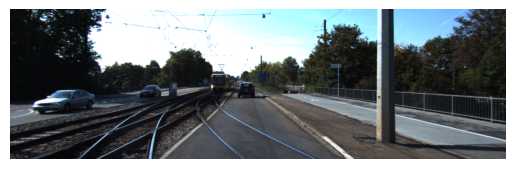

In [15]:
import matplotlib.pyplot as plt

# Access the image from the sample tuple
image = dataset[0][0]

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()



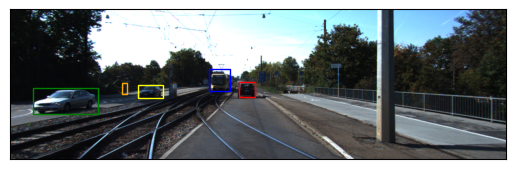

In [22]:
import matplotlib.pyplot as plt

# Get the image from the sample tuple
image = sample[0]

# Get the bounding boxes from the sample tuple
bounding_boxes = sample[1]

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Define a list of colors for different labels
colors = ['red', 'blue', 'green', 'yellow', 'orange']

# Iterate over the bounding boxes
for i, bbox in enumerate(bounding_boxes):
    # Get the label and bounding box coordinates
    label = bbox['type']
    x_min, y_min, x_max, y_max = bbox['bbox']
    
    # Get the color for the label
    color = colors[i % len(colors)]
    
    # Create a rectangle patch for the bounding box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor=color)
    
    # Add the rectangle patch to the axes
    ax.add_patch(rect)
    
    # Add the label as text near the bounding box
    # ax.text(x_min, y_min, label, color=color, fontsize=8, verticalalignment='top', bbox={'color': color, 'alpha': 0.5, 'pad': 0})
    
# Remove the axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [26]:
classes = 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'.split()
classes

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc',
 'DontCare']

In [27]:
class_names = [
    'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
    'Cyclist', 'Tram', 'Misc', 'DontCare'
]

# Create a dictionary to map class names to indices
class_to_idx = {class_name: idx + 1 for idx, class_name in enumerate(class_names)}
class_to_idx['background'] = 0  # Add background class

# Inverse mapping from indices to class names
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}


In [30]:
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = detection.fasterrcnn_resnet50_fpn(in_features, num_classes)
    return model

# Including background
model = get_model(num_classes=len(class_names) + 1)


/Users/sazzad14/Documents/Stanford/CS-231N/portalcut/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

class KittiDataset(Dataset):
    def __init__(self, annotations, transforms=None):
        """
        annotations: Path to the annotations file.
        transforms: Optional transforms to apply to the images.
        """
        self.annotations = json.load(open(annotations))
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # Load image and get label
        data = self.annotations[index]
        image = Image.open('path/to/image/' + data['image_id']).convert("RGB")
        box = data['bbox']

        # Convert box coordinates to PyTorch format [x, y, width, height]
        box = torch.tensor([box[0], box[1], box[2] - box[0], box[3] - box[1]])

        # Apply transformations
        if self.transforms:
            image = self.transforms(image)

        # Label (assuming binary classification: background=0, car=1)
        label = torch.tensor([1])  # As per your data handling logic

        # Return image and "target" dictionary for Faster R-CNN
        target = {}
        target['boxes'] = box.unsqueeze(0)  # Faster R-CNN expects boxes in a batch
        target['labels'] = label
        return image, target

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the dataset
dataset = KittiDataset('path/to/annotations.json', transforms=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [32]:
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Assuming use of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    lr_scheduler.step()


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>

In [5]:
import torchvision
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
import torch


def get_transform(train):
    transform = [transforms.ToTensor()]
    return transforms.Compose(transform)


# Define the custom dataset class using torchvision.datasets.Kitti
class KittiDataset(torchvision.datasets.Kitti):
    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        # Convert target format from list of dicts to the correct dict format
        labels = [1 + ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare'].index(t['type']) for t in target]
        boxes = [t['bbox'] for t in target]
        
        target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4), 'labels': torch.as_tensor(labels)}
        return image, target


# Now get, and show a sample data from the kitti dataset class defined above
dataset = KittiDataset(download=True, root='data', transform=get_transform(train=True)
sample = dataset[0]
image, target = sample
# print(sample)
print(image)
print(target)

print(KittiDataset.__len__(dataset))

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1242x375 at 0x107F11190>
{'boxes': tensor([[572.4400, 181.5600, 611.9500, 219.7100],
        [498.8500, 149.4900, 551.4000, 204.3200],
        [ 56.4600, 195.8900, 220.7800, 260.9100],
        [321.0800, 188.6500, 383.5200, 221.9300],
        [280.4000, 183.3500, 291.9000, 212.5600]]), 'labels': tensor([1, 7, 1, 1, 9])}
7481


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def draw_boxes(image, target, label_names):
    """
    Draws bounding boxes on an image.
    
    :param image: PIL Image object
    :param target: Dictionary with keys 'boxes' and 'labels', where:
                    - 'boxes' is a tensor of size (N, 4) for N bounding boxes (in xmin, ymin, xmax, ymax format)
                    - 'labels' is a tensor of size (N,) for label indices
    :param label_names: List of string names corresponding to label indices
    """
    # Convert PIL Image to numpy array for plotting
    np_image = np.array(image)
    
    # Create a matplotlib figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(np_image)
    
    # Get the boxes and labels from the target
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    
    # Draw each bounding box
    for box, label_idx in zip(boxes, labels):
        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label
        plt.text(box[0], box[1], label_names[label_idx], verticalalignment='top', color='white', fontsize=12, weight='bold')
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Assuming you have a PIL Image object (image) and a target dictionary
# label_names = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
# image = Image.open('path_to_your_image.jpg')
# target = {'boxes': torch.tensor([[572.4400, 181.5600, 611.9500, 219.7100], [498.8500, 149.4900, 551.4000, 204.3200], [56.4600, 195.8900, 220.7800, 260.9100], [321.0800, 188.6500, 383.5200, 220.9000], [280.4000, 183.3500, 291.9000, 212.5000]]), 'labels': torch.tensor([1, 7, 1, 1, 9])}

# draw_boxes(image, target, label_names)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sazzad14/Documents/Stanford/CS-231N/portalcut/path_to_your_image.jpg'

In [7]:

# Transformation
def get_transform(train):
    transform = [transforms.ToTensor()]
    if train:
        # Data augmentation policies
        transform.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transform)

# Initialize the dataset
def get_dataset(root, train):
    dataset = KittiDataset(root=root, train=train, transform=get_transform(train=train), download=True)
    return dataset

# Model setup
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = detection.fasterrcnn_resnet50_fpn(in_features, num_classes)
    return model

# Including background
# model = get_model(num_classes=len(class_names) + 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the datasets
root = 'data'  # Set this to your KITTI dataset path
train_dataset = get_dataset(root, train=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Define the model and optimizer
model = get_model(num_classes=10)  # 9 classes + background
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    print(data_loader)
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Loss: {losses.item()}')

print("Training complete")


  0%|          | 1867776/12569945557 [00:05<9:55:01, 352034.22it/s]


KeyboardInterrupt: 